In [19]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns

In [20]:
tolerancias = ['0.050000', '0.035000', '0.025000', '0.020000']
path_root = '../testing_results/test_movimiento_'
df_list = []

Levantamos los datos

In [21]:
path = "../testing_results/test_movimiento_0.020000.txt"
df_entero = pd.read_csv(path, sep=';')

for tolerancia in tolerancias :
    path = path_root + tolerancia + '.txt'
    df_list.append(pd.read_csv(path, sep=';'))
print(df_list[3])

          base  shoulder     elbow     pitch      roll  is_end_pose  move_id  \
0     0.005190  1.483447 -0.000033  0.024106 -0.002124            0        0   
1     0.005190  1.483447 -0.000033  0.023722 -0.002124            0        0   
2    -0.041162  1.437253  0.030769 -0.007076  0.044098            0        0   
3    -0.035269  1.432281  0.030501  0.009916  0.043137            0        0   
4    -0.087514  1.391058  0.061571 -0.038259  0.090320            0        0   
...        ...       ...       ...       ...       ...          ...      ...   
2443  0.052119  1.457302 -0.034871  0.045464 -0.053711            0        0   
2444  0.055003  1.459952 -0.035009  0.064428 -0.054739            0        0   
2445 -0.000026  1.483473  0.000032  0.011034 -0.001394            1        0   
2446  0.002561  1.485720 -0.000099  0.030461 -0.002451            1        0   
2447  0.000000  0.000000  0.000000  0.000000  0.000000            2        3   

      time_elapsed  
0                0

Agregamos cual a que movimiento corresponde cada posición

In [22]:
def discriminar_movimientos_goals_reales_y_esperados(df) :

    arr_de_ceros = [0]*len(df)
    arr_de_ceros_2 = [0]*len(df)
    df_discriminando_movimientos = df.assign(num_goal=arr_de_ceros)
    df_discriminando_movimientos = df_discriminando_movimientos.assign(es_el_esperado=arr_de_ceros_2)


    num_movimiento = 1
    num_de_goal = 1
    es_real = False

    for i, row in df_discriminando_movimientos.iterrows():
        df_discriminando_movimientos.at[i, 'num_goal'] = num_de_goal
        
        ## primero vemos si es un marcador de movimiento (is_end_pose = 2)
        if(row['is_end_pose'] == 2) :
            num_movimiento = (row['move_id'] % 3) + 1
            df_discriminando_movimientos.at[i,'num_goal'] = 0
            df_discriminando_movimientos.at[i-1, 'time_elapsed'] = row['time_elapsed']
            df_discriminando_movimientos.at[i-2, 'time_elapsed'] = row['time_elapsed']
        else:
            ## si no es marcador, es un dato y ahí vemos si es real o deseado
            df_discriminando_movimientos.at[i, 'move_id'] = num_movimiento
            if(not es_real) :
                df_discriminando_movimientos.at[i, 'es_el_esperado'] = 1
                es_real = True
            else :
                es_real = False
                num_de_goal = num_de_goal + 1
                if (row['is_end_pose'] == 1) :
                    num_de_goal = 1

    df_discriminando_movimientos = df_discriminando_movimientos.query('is_end_pose != 2')

    return df_discriminando_movimientos


In [23]:
df_entero_discriminando_movimientos = discriminar_movimientos_goals_reales_y_esperados(df_entero)

df_list_movs = []

for df in df_list :
    df_list_movs.append(discriminar_movimientos_goals_reales_y_esperados(df))

In [24]:
df_list_poses_finales = []
for df in df_list_movs :
    df_list_poses_finales.append(df.query('is_end_pose == 1'))

In [44]:
df_list_reales = []
df_list_esperados = []
for df in df_list_poses_finales : 
    df_list_reales.append(df.query('es_el_esperado == 0').drop(['is_end_pose','num_goal','es_el_esperado'],axis='columns'))
    df_list_esperados.append(df.query('es_el_esperado == 1').drop(['is_end_pose','num_goal','es_el_esperado'],axis='columns'))
    
print(df_list_reales[3])

          base  shoulder     elbow     pitch      roll  move_id  time_elapsed
69   -1.565445 -0.092416  1.044999 -1.018034  1.567813        1            40
182   1.564011  0.692337 -1.046908  1.038578 -1.570755        2            96
243   0.003619  1.485904  0.000066  0.030899 -0.002124        3            38
312  -1.567425 -0.092416  1.044835 -1.018198  1.567650        1            40
425   1.563943  0.698295 -1.046908  1.039236 -1.570264        2            92
486   0.002766  1.485812 -0.000033  0.030187 -0.002124        3            38
555  -1.564762 -0.092386  1.044901 -1.017376  1.567650        1            40
668   1.562952  0.692736 -1.046842  1.039290 -1.570755        2            94
729   0.006419  1.485751  0.000033  0.030078 -0.001797        3            38
800  -1.564591 -0.092816  1.045230 -1.016609  1.567977        1            41
913   1.563840  0.693012 -1.047006  1.038414 -1.570101        2            94
974   0.003209  1.485751 -0.000099  0.030899 -0.002124        3 

In [45]:
df_list_reales_primer_mov = []
df_list_reales_segundo_mov = []
df_list_reales_tercer_mov = []

df_list_esperados_primer_mov = []
df_list_esperados_segundo_mov = []
df_list_esperados_tercer_mov = []

for i in range(0,4) : 
    df_list_reales_primer_mov.append(df_list_reales[i].query('move_id == 1').drop(['move_id'], axis='columns'))
    df_list_reales_segundo_mov.append(df_list_reales[i].query('move_id == 2').drop(['move_id'], axis='columns'))
    df_list_reales_tercer_mov.append(df_list_reales[i].query('move_id == 3').drop(['move_id'], axis='columns'))

    df_list_esperados_primer_mov.append(df_list_esperados[i].query('move_id == 1').drop(['move_id'], axis='columns'))
    df_list_esperados_segundo_mov.append(df_list_esperados[i].query('move_id == 2').drop(['move_id'], axis='columns'))
    df_list_esperados_tercer_mov.append(df_list_esperados[i].query('move_id == 3').drop(['move_id'], axis='columns'))


In [49]:
df_list_reales_primer_mov[0]

,base,shoulder,elbow,pitch,roll,time_elapsed
69,-1.523143,-0.074880,1.051448,-1.006912,1.567813,24
314,-1.525123,-0.068000,1.051317,-0.999680,1.568140,23
557,-1.522835,-0.070211,1.051383,-1.001762,1.567813,24
800,-1.526728,-0.084124,1.051415,-1.004447,1.567650,24
1045,-1.527752,-0.072822,1.051317,-1.005049,1.567650,23
1290,-1.521265,-0.056606,1.053093,-0.996448,1.567650,23
1537,-1.522631,-0.045673,1.053390,-0.991407,1.567487,23
1780,-1.523177,-0.079149,1.051481,-1.001926,1.567977,23
2025,-1.527752,-0.066925,1.051383,-1.000338,1.567650,24
2270,-1.544618,-0.081728,1.049573,-1.007460,1.567487,22


In [67]:
tiempos_primer_mov = []
tiempos_segundo_mov = []
tiempos_tercer_mov = []

for i in range(0,4) :
    tiempos_primer_mov.append(df_list_reales_primer_mov[i]['time_elapsed'].reset_index(drop=True))
    tiempos_segundo_mov.append(df_list_reales_segundo_mov[i]['time_elapsed'].reset_index(drop=True))
    tiempos_tercer_mov.append(df_list_reales_tercer_mov[i]['time_elapsed'].reset_index(drop=True))

df_tiempos_primer_mov = pd.concat([tiempos_primer_mov[0].rename('0.05'), tiempos_primer_mov[1].rename('0.035'), tiempos_primer_mov[2].rename('0.025'), tiempos_primer_mov[3].rename('0.02')], axis=1)
df_tiempos_segundo_mov = pd.concat([tiempos_segundo_mov[0].rename('0.05'), tiempos_segundo_mov[1].rename('0.035'), tiempos_segundo_mov[2].rename('0.025'), tiempos_segundo_mov[3].rename('0.02')], axis=1)
df_tiempos_tercer_mov = pd.concat([tiempos_tercer_mov[0].rename('0.05'), tiempos_tercer_mov[1].rename('0.035'), tiempos_tercer_mov[2].rename('0.025'), tiempos_tercer_mov[3].rename('0.02')], axis=1)

print(df_tiempos_segundo_mov)

   0.05  0.035  0.025  0.02
0    53     56     72    96
1    53     58     74    92
2    53     55     73    94
3    54     56     74    94
4    52     56     74    93
5    53     54     74    96
6    55     56     72    96
7    55     58     73    95
8    54     57     73    92
9    51     56     72    93


          1     2     3
0.05   23.3  53.3  22.8
0.035  34.5  56.2  29.7
0.025  34.6  73.1  33.8
0.02   39.9  94.1  38.2


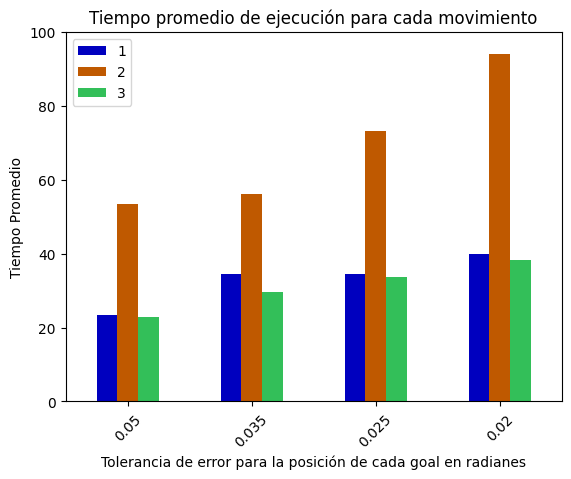

In [110]:
df_tiempos_avg = pd.concat([df_tiempos_primer_mov.mean().rename('1'), df_tiempos_segundo_mov.mean().rename('2'), df_tiempos_tercer_mov.mean().rename('3')], axis=1)
print(df_tiempos_avg)
my_colors = [(.0,.0,0.75), (0.75, .35, 0.0), (0.2, 0.75, 7.0/20.0)]

df_tiempos_avg.plot(kind='bar', color=my_colors)
plot.title("Tiempo promedio de ejecución para cada movimiento")
plot.ylabel("Tiempo Promedio")
plot.xlabel("Tolerancia de error para la posición de cada goal en radianes")
plot.xticks(rotation=45, horizontalalignment="center")
plot.ylim(0,100)

plot.savefig('tiempo_promedio_movimientos.png')

In [50]:
df_list_error_primer_mov = []
df_list_error_segundo_mov = []
df_list_error_tercer_mov = []

def error_entre_listas_dfs (reales, esperados) :
    errores = []
    for i in range(0, len(reales)) :
        df_real = reales[i].reset_index(drop=True).drop(['time_elapsed'], axis='columns')
        df_esperado = esperados[i].reset_index(drop=True).drop(['time_elapsed'], axis='columns')
        errores.append((df_esperado - df_real).abs())
    return errores

df_list_error_primer_mov = error_entre_listas_dfs(df_list_reales_primer_mov, df_list_esperados_primer_mov)
df_list_error_segundo_mov = error_entre_listas_dfs(df_list_reales_segundo_mov, df_list_esperados_segundo_mov)
df_list_error_tercer_mov = error_entre_listas_dfs(df_list_reales_tercer_mov, df_list_esperados_tercer_mov)

print(df_list_error_tercer_mov[3])
    

       base  shoulder     elbow     pitch      roll
0  0.003516  0.002411  0.000110  0.019790  0.000730
1  0.002662  0.002336  0.000106  0.019186  0.000867
2  0.006419  0.002278  0.000102  0.018966  0.000403
3  0.003081  0.002223  0.000125  0.019845  0.000771
4  0.007308  0.002734  0.000102  0.018915  0.000473
5  0.004274  0.002639  0.000115  0.019406  0.001037
6  0.005504  0.002551  0.000111  0.019010  0.000723
7  0.003657  0.002656  0.000104  0.019088  0.001103
8  0.005521  0.002554  0.000065  0.019088  0.000561
9  0.002587  0.002247  0.000131  0.019427  0.001057


In [51]:
df_list_primer_mov_error_avg = []
df_list_segundo_mov_error_avg = []
df_list_tercer_mov_error_avg = []

df_list_primer_mov_tiempo_avg = []
df_list_segundo_mov_tiempo_avg = []
df_list_tercer_mov_tiempo_avg = []

df_list_error_varianza = []

def error_promedio_para_cada_df_de_una_lista(errores, promedios) :
    for i in range(0, len(errores)) :
        promedios.append(errores[i].mean())

def varianza_para_cada_articulación_en_3_movimientos_para_cada_df_de_una_lista(errores_primero, errores_segundo, errores_tercero, varianzas) :
    errores_3_movimientos = pd.DataFrame()
    for i in range(0,len(errores_primero)) :
        errores_3_movimientos = pd.concat([errores_primero[i], errores_segundo[i], errores_tercero[i]])
        varianzas.append( errores_3_movimientos.var())


error_promedio_para_cada_df_de_una_lista(df_list_error_primer_mov, df_list_primer_mov_error_avg)
error_promedio_para_cada_df_de_una_lista(df_list_error_segundo_mov, df_list_segundo_mov_error_avg)
error_promedio_para_cada_df_de_una_lista(df_list_error_tercer_mov, df_list_tercer_mov_error_avg)

varianza_para_cada_articulación_en_3_movimientos_para_cada_df_de_una_lista(df_list_error_primer_mov, df_list_error_segundo_mov, df_list_error_tercer_mov, df_list_error_varianza)

print(df_list_segundo_mov_error_avg[1])
print(df_list_error_varianza[1])


base        0.007969
shoulder    0.006174
elbow       0.000182
pitch       0.026085
roll        0.001555
dtype: float64
base        3.410277e-05
shoulder    1.036096e-05
elbow       7.778142e-07
pitch       4.242531e-06
roll        1.725713e-07
dtype: float64


In [52]:
df_list_primer_mov_error_avg_porcentual = []
df_list_segundo_mov_error_avg_porcentual = []
df_list_tercer_mov_error_avg_porcentual = []



def error_porcentual_segun_tolerancia(errores, list_tolerancias, porcentuales) :
    for i in range(0, len(errores)) :
        porcentuales.append(errores[i] * 100 / float(list_tolerancias[i]))

error_porcentual_segun_tolerancia(df_list_primer_mov_error_avg, tolerancias, df_list_primer_mov_error_avg_porcentual)
error_porcentual_segun_tolerancia(df_list_segundo_mov_error_avg, tolerancias, df_list_segundo_mov_error_avg_porcentual)
error_porcentual_segun_tolerancia(df_list_tercer_mov_error_avg, tolerancias, df_list_tercer_mov_error_avg_porcentual)

print(df_list_tercer_mov_error_avg_porcentual[0])

base        89.9022
shoulder    20.0346
elbow        6.1264
pitch       73.0814
roll         1.8758
dtype: float64


In [53]:
joints = ['base', 'shoulder', 'elbow', 'pitch', 'roll']
tols = ['0.05', '0.035', '0.025', '0.02']
df_list_errors_by_joint = []
df_var = pd.DataFrame()

def get_joint_avgs_by_tolerance(df_list_move, joint, serie) :
    for i in range(0,4) :
        serie.at[tols[i]] = df_list_move[i][joint]

for joint in joints :
    joint_errors_primer = pd.Series()
    joint_errors_segundo = pd.Series()
    joint_errors_tercer = pd.Series()
    get_joint_avgs_by_tolerance(df_list_primer_mov_error_avg_porcentual, joint, joint_errors_primer)
    get_joint_avgs_by_tolerance(df_list_segundo_mov_error_avg_porcentual, joint, joint_errors_segundo)
    get_joint_avgs_by_tolerance(df_list_tercer_mov_error_avg_porcentual, joint, joint_errors_tercer)

    df_list_errors_by_joint.append(pd.concat([joint_errors_primer.rename('1'), joint_errors_segundo.rename('2'), joint_errors_tercer.rename('3')], axis=1))
    
df_var = pd.concat([df_list_error_varianza[0].rename('0.05'), df_list_error_varianza[1].rename('0.035'), df_list_error_varianza[2].rename('0.025'), df_list_error_varianza[3].rename('0.02')], axis=1)

print(df_list_errors_by_joint[0])
print(df_var)


               1          2          3
0.05   88.422600  48.465000  89.902200
0.035  36.088571  22.769143  14.881143
0.025  43.251600  27.458000  20.676800
0.02   22.783000  34.275500  22.264500
                  0.05         0.035         0.025          0.02
base      1.901645e-04  3.410277e-05  1.308058e-05  2.697632e-06
shoulder  8.152610e-05  1.036096e-05  2.400174e-06  3.004618e-06
elbow     4.000879e-06  7.778142e-07  3.835420e-07  1.145414e-06
pitch     1.973947e-05  4.242531e-06  2.587763e-06  5.017887e-07
roll      1.607033e-07  1.725713e-07  1.582616e-07  1.961657e-07


/tmp/ipykernel_12702/1498851610.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  joint_errors_primer = pd.Series()
/tmp/ipykernel_12702/1498851610.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  joint_errors_segundo = pd.Series()
/tmp/ipykernel_12702/1498851610.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  joint_errors_tercer = pd.Series()


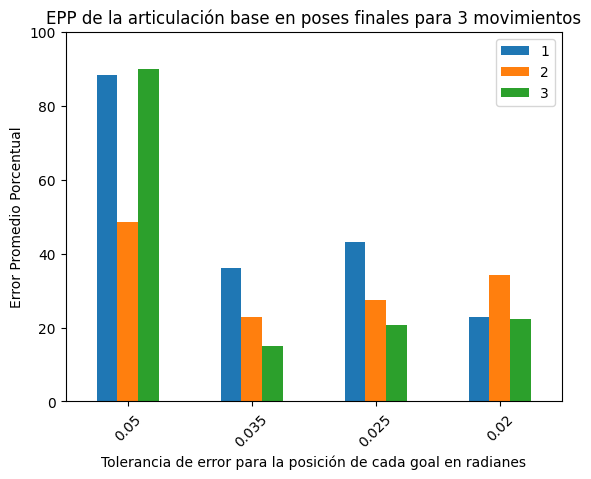

In [54]:
df_list_errors_by_joint[0].plot(kind='bar')
plot.title("EPP de la articulación base en poses finales para 3 movimientos")
plot.ylabel("Error Promedio Porcentual")
plot.xlabel("Tolerancia de error para la posición de cada goal en radianes")
plot.xticks(rotation=45, horizontalalignment="center")
plot.ylim(0,100)

plot.savefig('error_porcentual_base.png')

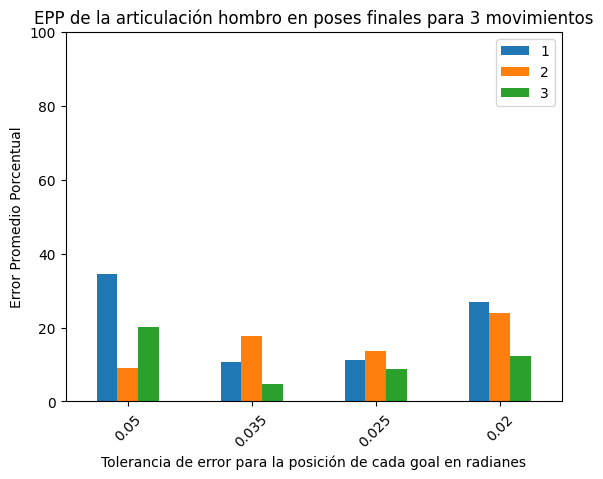

In [55]:
df_list_errors_by_joint[1].plot(kind='bar')
plot.title("EPP de la articulación hombro en poses finales para 3 movimientos")
plot.ylabel("Error Promedio Porcentual")
plot.xlabel("Tolerancia de error para la posición de cada goal en radianes")
plot.xticks(rotation=45, horizontalalignment="center")
plot.ylim(0,100)

plot.savefig('error_porcentual_hombro.png')

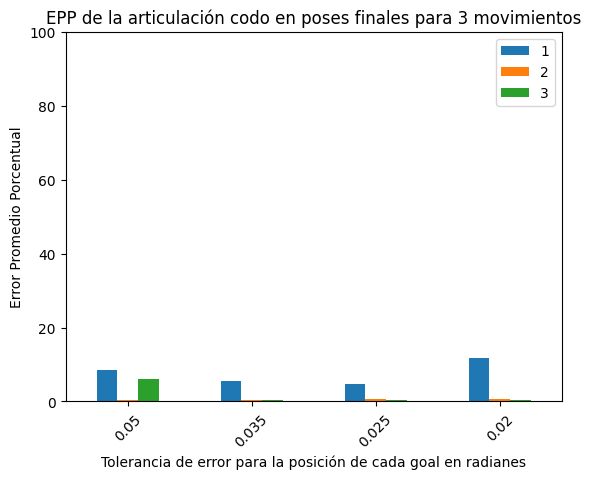

In [56]:
df_list_errors_by_joint[2].plot(kind='bar')
plot.title("EPP de la articulación codo en poses finales para 3 movimientos")
plot.ylabel("Error Promedio Porcentual")
plot.xlabel("Tolerancia de error para la posición de cada goal en radianes")
plot.xticks(rotation=45, horizontalalignment="center")
plot.ylim(0,100)

plot.savefig('error_porcentual_codo.png')

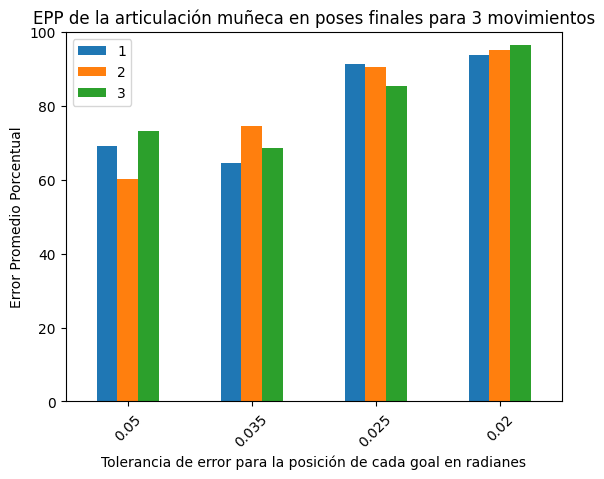

In [57]:
df_list_errors_by_joint[3].plot(kind='bar')
plot.title("EPP de la articulación muñeca en poses finales para 3 movimientos")
plot.ylabel("Error Promedio Porcentual")
plot.xlabel("Tolerancia de error para la posición de cada goal en radianes")
plot.xticks(rotation=45, horizontalalignment="center")
plot.ylim(0,100)

plot.savefig('error_porcentual_muneca.png')

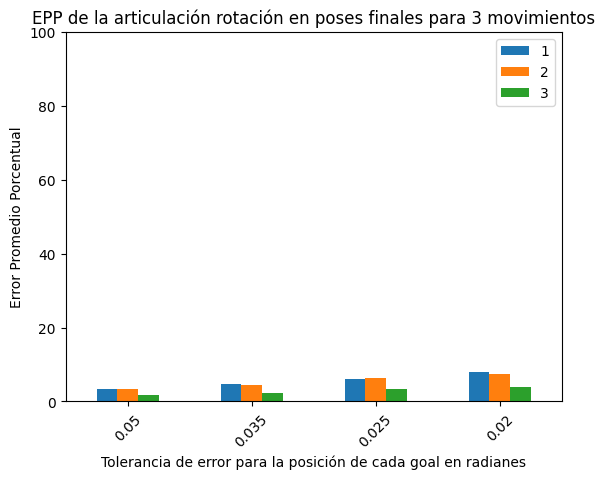

In [58]:
df_list_errors_by_joint[4].plot(kind='bar')
plot.title("EPP de la articulación rotación en poses finales para 3 movimientos")
plot.ylabel("Error Promedio Porcentual")
plot.xlabel("Tolerancia de error para la posición de cada goal en radianes")
plot.xticks(rotation=45, horizontalalignment="center")
plot.ylim(0,100)

plot.savefig('error_porcentual_rotacion.png')

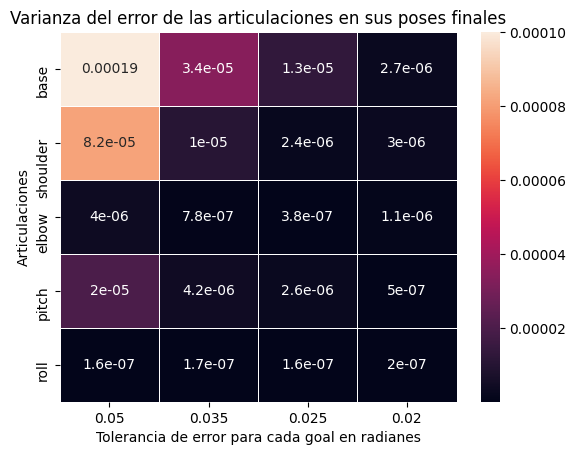

In [59]:
sns.heatmap(df_var, annot=True, linewidths=.5, vmax=1e-04)
plot.title('Varianza del error de las articulaciones en sus poses finales')
plot.ylabel("Articulaciones")
plot.xlabel('Tolerancia de error para cada goal en radianes')

plot.savefig('heatmap_var_error.png')